# MNIST
![](dl01.gif)  
MNISTは、主に画像認識を目的としたディープラーニング／機械学習の初心者向けチュートリアルでよく使われておいます。  
データがきれいに整形されているので「高い精度が出やすい」という特長があります。  
逆に言うと、MNISTでは精度が高すぎて、機械学習の手法間で精度を比較したい場合には使いづらいという欠点があります。


MNISTデータセット全体は、
・6万枚の訓練データ用（画像とラベル）
・1万枚のテストデータ用（画像とラベル）
合計7万枚
で構成される

各画像のフォーマットは  
・8bitグレースケール（＝色がないモノクローム）： 白「0」～黒「255」の256段階  
・幅28×高さ28フィールド（＝784フィールド)  
となっています。  
<span style="font-size: 100%; color: red;">
（※「フィールド」＝データを画像化する場合には「ピクセル」に対応します。RGBで作るグレースケールでは、0が黒で、255が白となり逆なので注意してください。)
</span>

# 用語解説

## 1:Epoch(エポック)数とは
エポック数とは、「一つの訓練データを何回繰り返して学習させるか」の数のことです。<br>
Deep Learningのようにパラメータの数が多いものになると、訓練データを何回も繰り返して学習させないとパラメータをうまく学習できないません(逆にやりすぎると過学習を起こすわけなんですが)。<br>
多すぎずに少なすぎないエポック数を指定することによって、パラメーターをうまく学習させることができます。

## 2:Accuracy
分子：True Positive + True Negative (予測が正しかったもの)  
分母： 全数<br>
Accuracyは、予測が正しかった割合をみるものです。

## 3:Loss
一言でいうと、クロスエントロピー。0~1の予測値を入力してモデルの性能を測る指標を出力します。  
分類モデルの性能を測る指標です。 (このLog lossへの)入力は0~1の確率の値を取ります。この値の<span style="font-size: 100%; color: red;">最小化</span>を目指します。完璧なモデルではLog lossが0になります。予測値が正解ラベルから離れるほどLog lossは<span style="font-size: 100%; color: red;">増加</span>します。


## AccuracyとLossの違い
Accuracyは予測した値と正解が一致していた数のカウントです。正解/不正解しかないのでいつも良い指標とはなりません（惜しかった、などが測れない）。
Log Lossは実際のラベルからどのくらい違っていたのかを考慮できます。

In [3]:
from __future__ import print_function

import argparse
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv1 = nn.Conv2d(1,16,2)

        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x =torch.softmax(x, dim=1)
        return x
    
def train_model(net, dataloders_dict, criterion, optimizer, num_epochs):
    
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    #初期設定
    #GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス", device)
    #モデルをGPUへ
    net.to(device)
    #ネットワークがある程度固定であれば高速化させる
    torch.backends.cudnn.benchmark = True
    #epochのループ
    for epoch in range(num_epochs):
        print('-----------------------------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-----------------------------------')

        #epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() #モデルを訓練モードに
            else:
                net.eval() #モデルを検証モードに
            epoch_loss = 0.0 #epochの損失0
            epoch_corrects = 0 #epochの正解数
            #データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm.tqdm(dataloders_dict[phase]):
                #optimizerを初期化
                optimizer.zero_grad()
                #順伝搬(forward)計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)#損失を計算
                    _, preds = torch.max(outputs, 1) #ラベルを予測
                    #訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    #イテレーション結果の計算
                    #lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    #正解の合計数を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            #epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloders_dict[phase].dataset)
            print('{} Loss:{:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))
            if phase == 'train':
                train_acc_list.append(epoch_acc)
                train_loss_list.append(epoch_loss)
            else:
                val_acc_list.append(epoch_acc)
                val_loss_list.append(epoch_loss)
    return val_loss_list,train_loss_list, val_acc_list, train_acc_list

import random
seed = 42
random.seed(seed)  
np.random.seed(seed)  
# PyTorch のRNGを初期化  
torch.manual_seed(seed)

import tensorflow as tf
import torch.utils.data as data
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 1, 28, 28).astype('float32')
x_test = x_test.reshape(10000, 1, 28, 28).astype('float32')

# 正規化
x_train /= 255
x_test /= 255

y_train = y_train.astype('long')
y_test = y_test.astype('long')


ds_train = data.TensorDataset(torch.from_numpy(x_train[0:10000]), torch.from_numpy(y_train[0:10000]))
ds_test  = data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

train_loader = data.DataLoader(dataset=ds_train, batch_size=1024, shuffle=True, num_workers=4) #, num_workers=4, worker_init_fn=worker_init_fn)
test_loader = data.DataLoader(dataset=ds_test, batch_size=1024, shuffle=False) #, num_workers=4, worker_init_fn=worker_init_fn)

dataloders_dict = {"train": train_loader, "val": test_loader}


model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.006)


val_loss, train_loss, val_acc, train_acc = train_model(model, dataloders_dict, criterion, optimizer, num_epochs=10)
torch.save(model.state_dict(), "mnist_cnn.pth")


  0%|          | 0/10 [00:00<?, ?it/s]

使用デバイス cpu
-----------------------------------
Epoch 1/10
-----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

train Loss:2.3075 Acc: 0.1301


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss:2.2498 Acc: 0.1840
-----------------------------------
Epoch 2/10
-----------------------------------


 10%|█         | 1/10 [00:00<00:01,  6.08it/s]

train Loss:2.1136 Acc: 0.3695


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss:1.9706 Acc: 0.5045
-----------------------------------
Epoch 3/10
-----------------------------------


 10%|█         | 1/10 [00:00<00:01,  5.71it/s]

train Loss:1.8991 Acc: 0.5706


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss:1.8498 Acc: 0.6164
-----------------------------------
Epoch 4/10
-----------------------------------


 10%|█         | 1/10 [00:00<00:01,  6.84it/s]

train Loss:1.8287 Acc: 0.6354


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss:1.8227 Acc: 0.6383
-----------------------------------
Epoch 5/10
-----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

train Loss:1.8114 Acc: 0.6498


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss:1.8157 Acc: 0.6427
-----------------------------------
Epoch 6/10
-----------------------------------


 10%|█         | 1/10 [00:00<00:01,  6.91it/s]

train Loss:1.7590 Acc: 0.7045


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss:1.6890 Acc: 0.7740
-----------------------------------
Epoch 7/10
-----------------------------------


 10%|█         | 1/10 [00:00<00:01,  6.78it/s]

train Loss:1.6509 Acc: 0.8141


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss:1.6346 Acc: 0.8291
-----------------------------------
Epoch 8/10
-----------------------------------


 10%|█         | 1/10 [00:00<00:01,  6.09it/s]

train Loss:1.6170 Acc: 0.8501


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss:1.6297 Acc: 0.8341
-----------------------------------
Epoch 9/10
-----------------------------------


 10%|█         | 1/10 [00:00<00:01,  5.36it/s]

train Loss:1.6103 Acc: 0.8535


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss:1.6215 Acc: 0.8414
-----------------------------------
Epoch 10/10
-----------------------------------


 10%|█         | 1/10 [00:00<00:01,  6.96it/s]

train Loss:1.5901 Acc: 0.8747


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


val Loss:1.5965 Acc: 0.8654


学習が完了しました。
次は、さっきの学習の推移をグラフ化してみます。

# 可視化

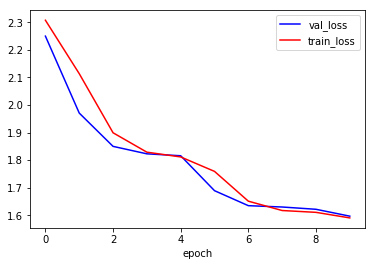

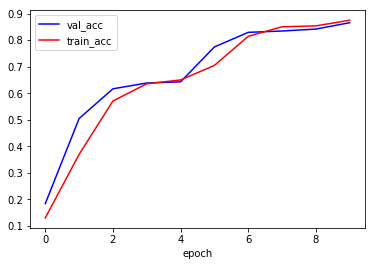

In [6]:
import matplotlib.pyplot as plt
#学習結果plot
plt.figure()
plt.plot(range(10), val_loss, 'b-', label='val_loss')
plt.plot(range(10), train_loss, 'r-', label='train_loss')
plt.legend()
plt.xlabel('epoch')
plt.show()

plt.figure()
plt.plot(range(10), val_acc, 'b-', label='val_acc')
plt.plot(range(10), train_acc, 'r-', label='train_acc')
plt.legend()
plt.xlabel('epoch')
plt.show()

しっかりと学習できていることがわかりました。
では、AIにとって未知のデータを分類してみましょう。

label6 predict7, 0.9936311841011047
label5 predict9, 0.9774420261383057
label2 predict3, 0.9520425796508789
label7 predict7, 0.9635797142982483
label4 predict7, 0.9999665021896362
label3 predict3, 0.9985836744308472
label1 predict6, 0.9997976422309875
label9 predict1, 0.9088256359100342
label8 predict3, 1.0


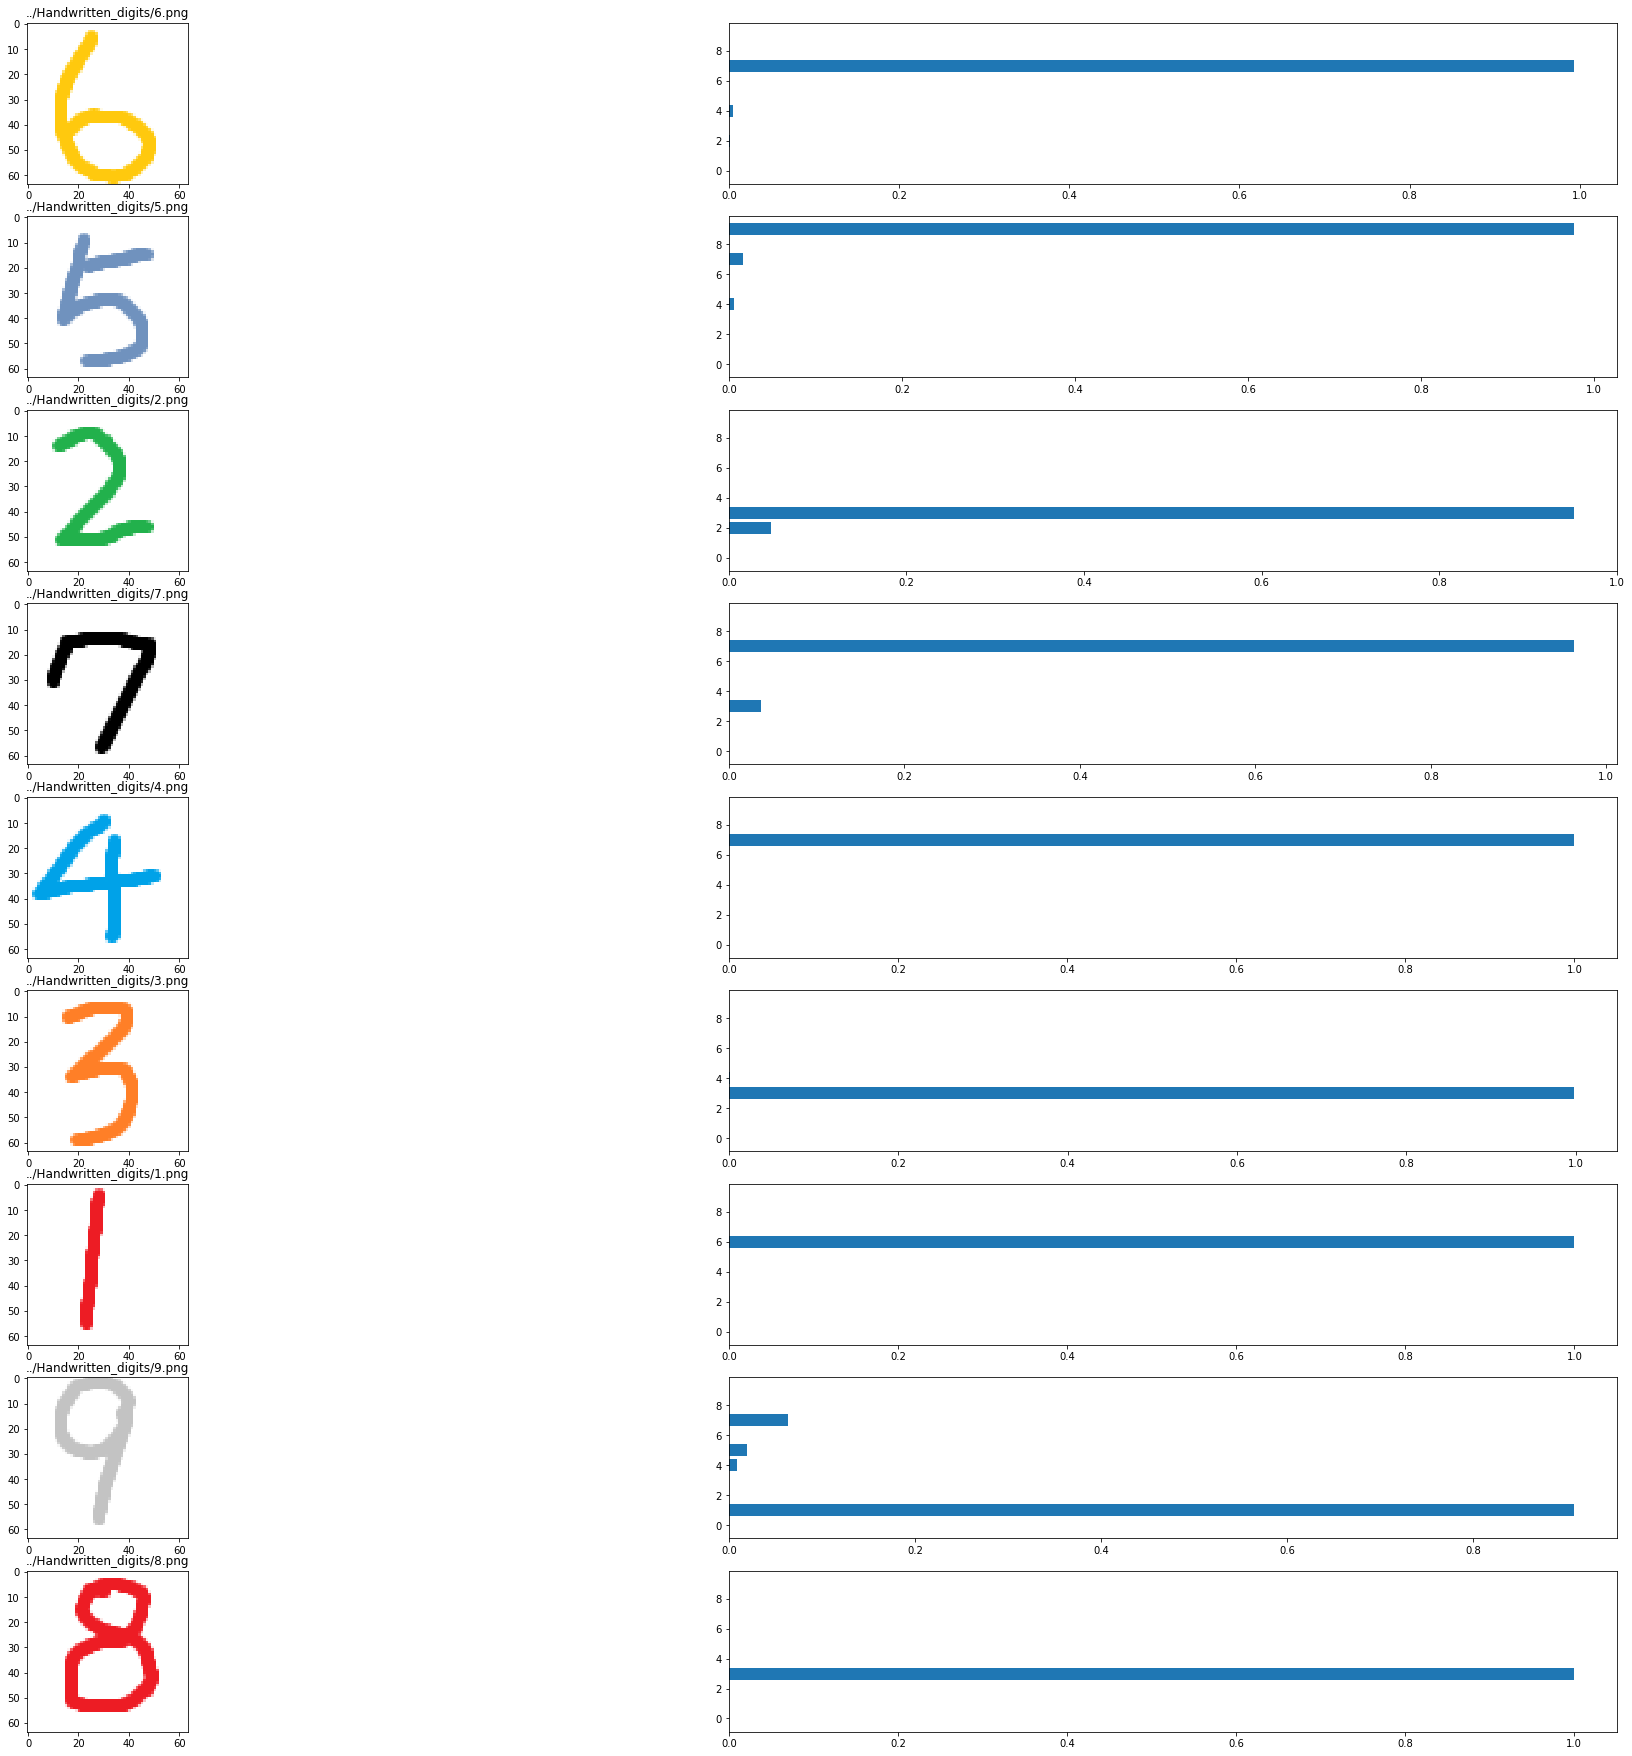

In [5]:
import  glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np

num_list = glob.glob("../Handwritten_digits/*")

result_list = []
fig = plt.figure(figsize=(35,35))
i = 0
for v in num_list:
    image = Image.open(v)
    ax = fig.add_subplot(10, 2, i + 1)
    ax.imshow(np.array(image))
    ax.set_title(v)
    # PyTorchで扱えるように変換(リサイズ、白黒反転、正規化、次元追加)
    image = ImageOps.invert(image.convert("L")).resize((28, 28))
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )
    image = transform(image).unsqueeze(0)
    # 予測を実施
    output = model(image)
    
    ax = fig.add_subplot(10, 2, i + 2)
    ax.barh(range(10), output.detach().numpy().tolist()[0])
    _, prediction = torch.max(output, 1)
    result = prediction[0].item()
    i += 2
    print("label{} predict{}, {}".format(v[-5:-4], result,output.detach().numpy().tolist()[0][result]))


既知のデータでは推論ができていますが、未知のデータではうまく判別ができない結果となりました。
次はこのモデルを改善していきたいと思います。  